In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
#import json
from urllib.request import urlopen
from pandas.io.json import json_normalize
#import seaborn as sns
#import matplotlib.colors as colors
%matplotlib inline 

Get the GeoJson information of the neighborhoods

In [2]:
!wget --quiet http://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson
ba_geo = r'barrios.geojson' # geojson file
print('Buenos Aires GeoJSON file downloaded!')

Buenos Aires GeoJSON file downloaded!


List all Neighborhoods in Buenos Aires

In [3]:
#Get the list of neighborhoods and to which commune it belongs. Also the average of m2 in dollars by neighborhood.
#We only have intererest in the last 3 years. 
url_sell = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/acceso-vivienda-y-mercado-inmobiliario/precio-venta-deptos.csv'
dfpv = pd.read_csv(url_sell)
#Last 3 years
sell_price_filtered = dfpv[dfpv['año'] > 2016]  
#List all Neighborhoods in Buenos Aires
neighborhoods = sell_price_filtered["barrio"].unique()
neighborhoods = pd.DataFrame(neighborhoods)
neighborhoods.rename(columns={0:"Neighborhood"}, inplace=True)
neighborhoods

Neighborhood
0           AGRONOMIA
1             ALMAGRO
2           BALVANERA
3            BARRACAS
4            BELGRANO
5                BOCA
6               BOEDO
7           CABALLITO
8           CHACARITA
9             COGHLAN
10         COLEGIALES
11       CONSTITUCION
12             FLORES
13           FLORESTA
14             PATERL
15            LINIERS
16          MATADEROS
17       MONTE CASTRO
18          MONSERRAT
19      NUEVA POMPEYA
20              NUÑEZ
21            PALERMO
22  PARQUE AVELLANEDA
23   PARQUE CHACABUCO
24        PARQUE CHAS
25   PARQUE PATRICIOS
26      PUERTO MADERO
27           RECOLETA
28             RETIRO
29           SAAVEDRA
30      SAN CRISTOBAL
31        SAN NICOLAS
32          SAN TELMO
33    VELEZ SARSFIELD
34          VERSALLES
35       VILLA CRESPO
36   VILLA DEL PARQUE
37       VILLA DEVOTO
38  VILLA GRAL. MITRE
39       VILLA LUGANO
40         VILLA LURO
41      VILLA ORTUZAR
42   VILLA PUEYRREDON
43         VILLA REAL
44    VILLA RIACHUELO
45   VILLA SANTA RITA
46      VILLA SOLDATI
47      VILLA URQUIZA

Rename columns to English

In [5]:
sell_price_filtered.rename(columns={"barrio": "Neighborhood", "año": "year", "trimestre": "quarter","precio_prom": "avg_price", "ambientes": "rooms", "estado": "status","comuna": "commune"}, inplace=True)
sell_price_filtered.head()

Neighborhood  year  quarter  avg_price        rooms status  commune
28    AGRONOMIA  2017        1     2140.0  2 ambientes  Usado       15
29    AGRONOMIA  2017        2     2203.0  2 ambientes  Usado       15
30    AGRONOMIA  2017        3     2303.0  2 ambientes  Usado       15
31    AGRONOMIA  2017        4        NaN  2 ambientes  Usado       15
32    AGRONOMIA  2018        1        NaN  2 ambientes  Usado       15

More translation and data wrangling

In [7]:
sell_price_filtered["rooms"].replace('ambientes','', regex=True, inplace=True)
sell_price_filtered["status"].replace('Usado','Used', regex=True, inplace=True)
sell_price_filtered["status"].replace('A estrer','New', regex=True, inplace=True)
sell_price_filtered

Neighborhood  year  quarter  avg_price rooms status  commune
28        AGRONOMIA  2017        1     2140.0    2    Used       15
29        AGRONOMIA  2017        2     2203.0    2    Used       15
30        AGRONOMIA  2017        3     2303.0    2    Used       15
31        AGRONOMIA  2017        4        NaN    2    Used       15
32        AGRONOMIA  2018        1        NaN    2    Used       15
...             ...   ...      ...        ...   ...    ...      ...
7291  VILLA URQUIZA  2018        2     3353.0    3     New       12
7292  VILLA URQUIZA  2018        3     3329.0    3     New       12
7293  VILLA URQUIZA  2018        4     3316.0    3     New       12
7294  VILLA URQUIZA  2019        1     3424.0    3     New       12
7295  VILLA URQUIZA  2019        2     3344.0    3     New       12

[1920 rows x 7 columns]

Clean the rows with Nan values

In [8]:
sell_price_filtered = sell_price_filtered.dropna()
sell_price_filtered

Neighborhood  year  quarter  avg_price rooms status  commune
28        AGRONOMIA  2017        1     2140.0    2    Used       15
29        AGRONOMIA  2017        2     2203.0    2    Used       15
30        AGRONOMIA  2017        3     2303.0    2    Used       15
66          ALMAGRO  2017        1     2282.0    2    Used        5
67          ALMAGRO  2017        2     2290.0    2    Used        5
...             ...   ...      ...        ...   ...    ...      ...
7291  VILLA URQUIZA  2018        2     3353.0    3     New       12
7292  VILLA URQUIZA  2018        3     3329.0    3     New       12
7293  VILLA URQUIZA  2018        4     3316.0    3     New       12
7294  VILLA URQUIZA  2019        1     3424.0    3     New       12
7295  VILLA URQUIZA  2019        2     3344.0    3     New       12

[1076 rows x 7 columns]




Let's see which are the best valued neighborhoods in the real estate market. 

We will group the information of the average sales per quarter, regardless of whether the apartment is new or not or if it is 2 or 3 rooms. 
We want to find out what are the 10 neighborhoods where the price of the m2 is higher, which 
indicates that the purchasing power of the neighborhood is also high.

Since we are trying to sell a differentiated product and that we have our public well targeted, we want to see which neighborhoods meet those conditions.

We are going to group the data and get the average price per neighborhood of the last 3 years. Those are going to be our 10 candidate neighborhoods.

In [9]:
top_ten = sell_price_filtered.groupby(["Neighborhood"],as_index=False).mean().sort_values("avg_price", ascending=False, inplace=False).head(10)
top_ten

Neighborhood         year   quarter    avg_price  commune
25  PUERTO MADERO  2017.761905  2.238095  6030.571429      1.0
26       RECOLETA  2017.800000  2.300000  3751.450000      2.0
19        PALERMO  2017.800000  2.300000  3708.200000     14.0
4        BELGRANO  2017.800000  2.300000  3637.375000     13.0
18          NUÑEZ  2017.833333  2.277778  3515.777778     13.0
10     COLEGIALES  2017.852941  2.264706  3302.294118     13.0
43  VILLA URQUIZA  2017.800000  2.300000  3127.575000     12.0
9         COGHLAN  2017.647059  2.235294  3091.352941     12.0
27         RETIRO  2017.800000  2.300000  3010.300000      1.0
7       CABALLITO  2017.800000  2.300000  2925.300000      6.0

<Figure size 432x288 with 0 Axes>

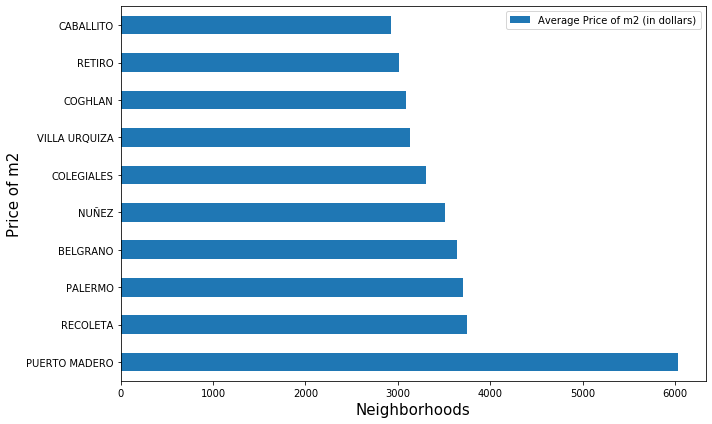

In [10]:
fig = plt.figure()
ax = top_ten.plot(kind='barh', x="Neighborhood", y="avg_price", figsize=(10,6))
ax.legend(["Average Price of m2 (in dollars)"]);
fig = ax.get_figure()
ax.set_ylabel("Price of m2",fontsize = 15)
ax.set_xlabel("Neighborhoods",fontsize = 15)
fig.tight_layout()
fig.savefig("avg_m2.png")

We see that Puerto Madero is the most expensive neighborhood to buy in Buenos Aires with $ 6030 dollars per square meter. Recoleta and Palermo are behind with a much lower value. We can also observe that Caballito is the neighborhood with the lowest m2 price.

In [11]:
top_ten.drop(columns=["commune"], inplace=True)
top_ten.rename(columns={"year" : "lat","quarter" : "lon"}, inplace=True)
top_ten

Neighborhood          lat       lon    avg_price
25  PUERTO MADERO  2017.761905  2.238095  6030.571429
26       RECOLETA  2017.800000  2.300000  3751.450000
19        PALERMO  2017.800000  2.300000  3708.200000
4        BELGRANO  2017.800000  2.300000  3637.375000
18          NUÑEZ  2017.833333  2.277778  3515.777778
10     COLEGIALES  2017.852941  2.264706  3302.294118
43  VILLA URQUIZA  2017.800000  2.300000  3127.575000
9         COGHLAN  2017.647059  2.235294  3091.352941
27         RETIRO  2017.800000  2.300000  3010.300000
7       CABALLITO  2017.800000  2.300000  2925.300000

In [12]:
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

In [13]:
top_ten["lat"] = 0.0
top_ten["lon"] = 0.0
top_ten

Neighborhood  lat  lon    avg_price
25  PUERTO MADERO  0.0  0.0  6030.571429
26       RECOLETA  0.0  0.0  3751.450000
19        PALERMO  0.0  0.0  3708.200000
4        BELGRANO  0.0  0.0  3637.375000
18          NUÑEZ  0.0  0.0  3515.777778
10     COLEGIALES  0.0  0.0  3302.294118
43  VILLA URQUIZA  0.0  0.0  3127.575000
9         COGHLAN  0.0  0.0  3091.352941
27         RETIRO  0.0  0.0  3010.300000
7       CABALLITO  0.0  0.0  2925.300000

I defined a function to obtain the geographic coordinates of an address using the Nominatim service. I used a recursive function to call the service again in case of timeout

In [14]:
from geopy.exc import GeocoderTimedOut
str_city = ', Buenos Aires'


def get_location(address):
    try:
        coord = []
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        coord.append(latitude)
        coord.append(longitude)
        print('The geograpical coordinate of {} are {}, {}.'.format(address, coord[0], coord[1]))
        return coord
    except GeocoderTimedOut: #Get rid of Nominatim TimeOut
        return get_location(address)

We search the coordinates of each neighborhood and add them to our candidate neighborhoods

In [15]:
for i, row in top_ten.iterrows():
    address = row[0]+str_city
    print("Adress:" , address) 
    res = get_location(address)
    top_ten.at[i, "lat"] = res[0]
    top_ten.at[i, "lon"] = res[1]
    
top_ten

Adress: PUERTO MADERO, Buenos Aires
The geograpical coordinate of PUERTO MADERO, Buenos Aires are -34.6103764, -58.3622067.
Adress: RECOLETA, Buenos Aires
The geograpical coordinate of RECOLETA, Buenos Aires are -34.587358, -58.39157.
Adress: PALERMO, Buenos Aires
The geograpical coordinate of PALERMO, Buenos Aires are -34.5803362, -58.4245236.
Adress: BELGRANO, Buenos Aires
The geograpical coordinate of BELGRANO, Buenos Aires are -34.5613076, -58.4565454.
Adress: NUÑEZ, Buenos Aires
The geograpical coordinate of NUÑEZ, Buenos Aires are -34.5453484, -58.4621491.
Adress: COLEGIALES, Buenos Aires
The geograpical coordinate of COLEGIALES, Buenos Aires are -34.5745154, -58.4522819.
Adress: VILLA URQUIZA, Buenos Aires
The geograpical coordinate of VILLA URQUIZA, Buenos Aires are -34.5732414, -58.4914785.
Adress: COGHLAN, Buenos Aires
The geograpical coordinate of COGHLAN, Buenos Aires are -34.5599096, -58.4747142.
Adress: RETIRO, Buenos Aires
The geograpical coordinate of RETIRO, Buenos Air

Neighborhood        lat        lon    avg_price
25  PUERTO MADERO -34.610376 -58.362207  6030.571429
26       RECOLETA -34.587358 -58.391570  3751.450000
19        PALERMO -34.580336 -58.424524  3708.200000
4        BELGRANO -34.561308 -58.456545  3637.375000
18          NUÑEZ -34.545348 -58.462149  3515.777778
10     COLEGIALES -34.574515 -58.452282  3302.294118
43  VILLA URQUIZA -34.573241 -58.491478  3127.575000
9         COGHLAN -34.559910 -58.474714  3091.352941
27         RETIRO -34.591643 -58.373307  3010.300000
7       CABALLITO -34.620077 -58.442489  2925.300000

Installation / import of the libraries needed for our maps

In [16]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


We look for the coordinates of Buenos Aires and define the city center. We use the price information of the 10 candidates on a choropleth map. We save the map information in an html file.

In [17]:
ba_center = get_location('Buenos Aires')

ba = folium.Map(location=[ba_center[0], ba_center[1]], zoom_start=12)

ba.choropleth(
    geo_data=ba_geo,
    data=top_ten,
    columns=['Neighborhood', 'avg_price'],
    key_on='feature.properties.barrio',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name="Average Price of m2 (in dollars)"
)
# display map
ba.save('ba_map.html')
ba

The geograpical coordinate of Buenos Aires are -34.6075682, -58.4370894.


We add some more information to the map, such as names and define the boundaries of each neighborhood

In [18]:
folium.GeoJson(ba_geo, name='geojson').add_to(ba)
for name, lat, lon in zip(top_ten.Neighborhood, top_ten.lat, top_ten.lon):
    folium.Marker(location=[lat, lon],icon=folium.DivIcon(html=name)).add_to(ba)
ba.save("map.html")
ba

#### Ok, we already have listed, identified, valued and visualized the 10 most expensive neighborhoods in Buenos Aires. With this we limit the search to neighborhoods with high purchasing power since we are looking for a place to sell our product that is different from the others, of high quality.
#### We have identified what our target audience is and we also know that coffee gets along very well with the arts among other things. That is why we are going to look for libraries, bookshops, film and TV studios, theaters, cultural centers, etc., to find out where we have more possibilities to have customers to consume our coffee.

We use the information of Cultural Dependencies obtained directly from the datasets provided by the Government of the City of Buenos Aires.

In [19]:
url = "http://cdn.buenosaires.gob.ar/datosabiertos/datasets/dependencias-culturales/dependencias-culturales.csv" 
df_cult = pd.read_csv(url, sep=';')
df_cult.head()


LAT        LNG    ID  \
0 -34.609173 -58.384297   192   
1 -34.596817 -58.383559  1467   
2 -34.609848 -58.370739  1788   
3 -34.618628 -58.385471   296   
4 -34.611321 -58.372772  1147   

                                              NOMBRE                  CALLE  \
0                                        36 BILLARES            DE MAYO AV.   
1                                                ABM  ALVEAR, MARCELO T. DE   
2  ACADEMIA NACIONAL DE LA HISTORIA DE LA REPUBLI...               BALCARCE   
3                      ACADEMIA PORTEÑA DEL LUNFARDO         ESTADOS UNIDOS   
4                                             ACCION                 MORENO   

   ALTURA PISO_DEPTO       DIRECCION_NORMALIZADA        BARRIO     COMUNA  \
0    1265        NaN            DE MAYO AV. 1265     MONSERRAT  COMUNA 01   
1    1155        NaN  ALVEAR, MARCELO T. DE 1155        RETIRO  COMUNA 01   
2     139        NaN                BALCARCE 139     MONSERRAT  COMUNA 01   
3    1379        NaN         ESTADOS UNIDOS 1379  CONSTITUCION  COMUNA 01   
4     457        NaN                  MORENO 457     MONSERRAT  COMUNA 01   

   ...       CPA                    DIAS_Y_HORARIO  \
0  ...  C1085ABC                               NaN   
1  ...  C1058AAQ         LUNES A VIERNES DE 9 A 22   
2  ...  C1064AAC                               NaN   
3  ...  C1101ABA  LUNES A VIERNES DE 14:00 A 19:00   
4  ...  C1091AAI                               NaN   

                            TELEFONOS                       EMAIL  \
0                           4381-5696   INFO@LOS36BILLARES.COM.AR   
1                    4816-1314 / 1644             INFO@ABM.EDU.AR   
2  343-4416 // 4331-4633 // 4331-5147                         NaN   
3                           4383-2393  OLIVIERIEDITOR@HOTMAIL.COM   
4                           4343-6474                         NaN   

                                   WEB  \
0             WWW.LOS36BILLARES.COM.AR   
1                       WWW.ABM.EDU.AR   
2               WWW.AN-HISTORIA.ORG.AR   
3  HTTP://WWW.TODOTANGO.COM/ALUNFARDO/   
4                                  NaN   

                                      ACTIVIDAD OTRAS_ACTIDADES DEPENDENCIA  \
0                                   BAR NOTABLE             NaN         NaN   
1  ESPACIO DE FORMACION (SEMINARIOS Y TALLERES)             NaN         NaN   
2                                         MUSEO             NaN         NaN   
3  ESPACIO DE FORMACION (SEMINARIOS Y TALLERES)             NaN         NaN   
4                                      LIBRERIA             NaN         NaN   

   PUBLICO   SECTOR  
0  GENERAL  PRIVADO  
1  GENERAL  PRIVADO  
2  GENERAL      ONG  
3  GENERAL      ONG  
4  GENERAL  PRIVADO  

[5 rows x 21 columns]

We remove the columns in which we have no interest

In [20]:
df_cult.drop(columns=[ 'CALLE', 'ALTURA', 'PISO_DEPTO',
       'DIRECCION_NORMALIZADA','ID','COMUNA', 'CP', 'CPA',
       'DIAS_Y_HORARIO', 'TELEFONOS', 'EMAIL', 'WEB', 
       'OTRAS_ACTIDADES', 'DEPENDENCIA', 'PUBLICO', 'SECTOR',],inplace=True)

In [21]:
df_cult.head()

LAT        LNG                                             NOMBRE  \
0 -34.609173 -58.384297                                        36 BILLARES   
1 -34.596817 -58.383559                                                ABM   
2 -34.609848 -58.370739  ACADEMIA NACIONAL DE LA HISTORIA DE LA REPUBLI...   
3 -34.618628 -58.385471                      ACADEMIA PORTEÑA DEL LUNFARDO   
4 -34.611321 -58.372772                                             ACCION   

         BARRIO                                     ACTIVIDAD  
0     MONSERRAT                                   BAR NOTABLE  
1        RETIRO  ESPACIO DE FORMACION (SEMINARIOS Y TALLERES)  
2     MONSERRAT                                         MUSEO  
3  CONSTITUCION  ESPACIO DE FORMACION (SEMINARIOS Y TALLERES)  
4     MONSERRAT                                      LIBRERIA

Translation to english

In [22]:
df_cult.rename(columns={"NOMBRE": "Name", "BARRIO": "Neighborhood", "ACTIVIDAD": "Category"}, inplace=True)
df_cult

LAT        LNG                                               Name  \
0    -34.609173 -58.384297                                        36 BILLARES   
1    -34.596817 -58.383559                                                ABM   
2    -34.609848 -58.370739  ACADEMIA NACIONAL DE LA HISTORIA DE LA REPUBLI...   
3    -34.618628 -58.385471                      ACADEMIA PORTEÑA DEL LUNFARDO   
4    -34.611321 -58.372772                                             ACCION   
...         ...        ...                                                ...   
2091 -34.658314 -58.479628                                          SAN JORGE   
2092 -34.647305 -58.465376  SOCIEDAD DE FOMENTO MARIANO ACOSTA - MILONGA L...   
2093 -34.661620 -58.501420                  TANGO EN EL CENTRO SOCIAL CHICAGO   
2094 -34.653429 -58.504622                                         TAXCO CAFE   
2095 -34.645591 -58.484808                                      TRES AVENIDAS   

           Neighborhood                                      Category  
0             MONSERRAT                                   BAR NOTABLE  
1                RETIRO  ESPACIO DE FORMACION (SEMINARIOS Y TALLERES)  
2             MONSERRAT                                         MUSEO  
3          CONSTITUCION  ESPACIO DE FORMACION (SEMINARIOS Y TALLERES)  
4             MONSERRAT                                      LIBRERIA  
...                 ...                                           ...  
2091          MATADEROS                                      LIBRERIA  
2092  PARQUE AVELLANEDA                         MILONGA Y/O TANGUERIA  
2093          MATADEROS                         MILONGA Y/O TANGUERIA  
2094          MATADEROS                              BAR IDENTIFICADO  
2095  PARQUE AVELLANEDA                                  BAR ELEMENTO  

[2096 rows x 5 columns]

Reindex the dataframe

In [23]:
df_cult = df_cult.reindex(columns=['Name','Neighborhood','Category','LAT','LNG'])
df_cult

Name       Neighborhood  \
0                                           36 BILLARES          MONSERRAT   
1                                                   ABM             RETIRO   
2     ACADEMIA NACIONAL DE LA HISTORIA DE LA REPUBLI...          MONSERRAT   
3                         ACADEMIA PORTEÑA DEL LUNFARDO       CONSTITUCION   
4                                                ACCION          MONSERRAT   
...                                                 ...                ...   
2091                                          SAN JORGE          MATADEROS   
2092  SOCIEDAD DE FOMENTO MARIANO ACOSTA - MILONGA L...  PARQUE AVELLANEDA   
2093                  TANGO EN EL CENTRO SOCIAL CHICAGO          MATADEROS   
2094                                         TAXCO CAFE          MATADEROS   
2095                                      TRES AVENIDAS  PARQUE AVELLANEDA   

                                          Category        LAT        LNG  
0                                      BAR NOTABLE -34.609173 -58.384297  
1     ESPACIO DE FORMACION (SEMINARIOS Y TALLERES) -34.596817 -58.383559  
2                                            MUSEO -34.609848 -58.370739  
3     ESPACIO DE FORMACION (SEMINARIOS Y TALLERES) -34.618628 -58.385471  
4                                         LIBRERIA -34.611321 -58.372772  
...                                            ...        ...        ...  
2091                                      LIBRERIA -34.658314 -58.479628  
2092                         MILONGA Y/O TANGUERIA -34.647305 -58.465376  
2093                         MILONGA Y/O TANGUERIA -34.661620 -58.501420  
2094                              BAR IDENTIFICADO -34.653429 -58.504622  
2095                                  BAR ELEMENTO -34.645591 -58.484808  

[2096 rows x 5 columns]

In [24]:
df_cult['Category'].unique()

array(['BAR NOTABLE', 'ESPACIO DE FORMACION (SEMINARIOS Y TALLERES)',
       'MUSEO', 'LIBRERIA', 'EDITORIAL', 'BAR IDENTIFICADO',
       'SELLO DISCOGRAFICO', 'GALERIA DE ARTE', 'CENTRO CULTURAL',
       'RADIO LOCAL (AM Y FM)',
       'ESPACIO ESCENICO (TEATRO, MUSICA Y DANZA)',
       'PRODUCTORA AUDIOVISUAL', 'ARCHIVO', 'BIBLIOTECA', 'CINE',
       'BAR CULTURAL', 'DISQUERIA', 'CALESITA', 'MILONGA Y/O TANGUERIA',
       'BAR ELEMENTO', 'SALA DE EXPOSICION', 'TELEVISION LOCAL',
       'ESPACIO CULTURAL', 'PEÑA', 'PLANETARIO', 'CIRCO'], dtype=object)

In [25]:
df_cult

Name       Neighborhood  \
0                                           36 BILLARES          MONSERRAT   
1                                                   ABM             RETIRO   
2     ACADEMIA NACIONAL DE LA HISTORIA DE LA REPUBLI...          MONSERRAT   
3                         ACADEMIA PORTEÑA DEL LUNFARDO       CONSTITUCION   
4                                                ACCION          MONSERRAT   
...                                                 ...                ...   
2091                                          SAN JORGE          MATADEROS   
2092  SOCIEDAD DE FOMENTO MARIANO ACOSTA - MILONGA L...  PARQUE AVELLANEDA   
2093                  TANGO EN EL CENTRO SOCIAL CHICAGO          MATADEROS   
2094                                         TAXCO CAFE          MATADEROS   
2095                                      TRES AVENIDAS  PARQUE AVELLANEDA   

                                          Category        LAT        LNG  
0                                      BAR NOTABLE -34.609173 -58.384297  
1     ESPACIO DE FORMACION (SEMINARIOS Y TALLERES) -34.596817 -58.383559  
2                                            MUSEO -34.609848 -58.370739  
3     ESPACIO DE FORMACION (SEMINARIOS Y TALLERES) -34.618628 -58.385471  
4                                         LIBRERIA -34.611321 -58.372772  
...                                            ...        ...        ...  
2091                                      LIBRERIA -34.658314 -58.479628  
2092                         MILONGA Y/O TANGUERIA -34.647305 -58.465376  
2093                         MILONGA Y/O TANGUERIA -34.661620 -58.501420  
2094                              BAR IDENTIFICADO -34.653429 -58.504622  
2095                                  BAR ELEMENTO -34.645591 -58.484808  

[2096 rows x 5 columns]

More translations and data wrangling

In [26]:
df_cult["Category"].replace(to_replace=r'(BAR \w*)', value='BAR', regex=True, inplace=True)
df_cult["Category"].replace(to_replace=r'\w*.(CULT\w*)', value='CULTURAL CENTER', regex=True, inplace=True) 
df_cult["Category"].replace('GALERIA DE ARTE', 'ART GALLERY', inplace=True) 
df_cult["Category"].replace('ESPACIO ESCENICO (TEATRO, MUSICA Y DANZA)', 'SCENICAL SPACE (THEATER, MUSIC AND DANCE)', regex=True, inplace=True) 
df_cult["Category"].replace('BIBLIOTECA', 'LIBRARY', inplace=True)
df_cult["Category"].replace('LIBRERIA', 'BOOKSHOP', inplace=True)
df_cult["Category"].replace('TELEVISION LOCAL', 'TV', inplace=True)
df_cult["Category"].replace('PRODUCTORA AUDIOVISUAL', 'AUDIOVISUAL PRODUCTION', inplace=True)

df_cult

Name       Neighborhood  \
0                                           36 BILLARES          MONSERRAT   
1                                                   ABM             RETIRO   
2     ACADEMIA NACIONAL DE LA HISTORIA DE LA REPUBLI...          MONSERRAT   
3                         ACADEMIA PORTEÑA DEL LUNFARDO       CONSTITUCION   
4                                                ACCION          MONSERRAT   
...                                                 ...                ...   
2091                                          SAN JORGE          MATADEROS   
2092  SOCIEDAD DE FOMENTO MARIANO ACOSTA - MILONGA L...  PARQUE AVELLANEDA   
2093                  TANGO EN EL CENTRO SOCIAL CHICAGO          MATADEROS   
2094                                         TAXCO CAFE          MATADEROS   
2095                                      TRES AVENIDAS  PARQUE AVELLANEDA   

                                          Category        LAT        LNG  
0                                              BAR -34.609173 -58.384297  
1     ESPACIO DE FORMACION (SEMINARIOS Y TALLERES) -34.596817 -58.383559  
2                                            MUSEO -34.609848 -58.370739  
3     ESPACIO DE FORMACION (SEMINARIOS Y TALLERES) -34.618628 -58.385471  
4                                         BOOKSHOP -34.611321 -58.372772  
...                                            ...        ...        ...  
2091                                      BOOKSHOP -34.658314 -58.479628  
2092                         MILONGA Y/O TANGUERIA -34.647305 -58.465376  
2093                         MILONGA Y/O TANGUERIA -34.661620 -58.501420  
2094                                           BAR -34.653429 -58.504622  
2095                                           BAR -34.645591 -58.484808  

[2096 rows x 5 columns]

We extract all the Libraries and Book Shops and visualize the results on the map

In [27]:
cat = ['LIBRARY' , 'BOOKSHOP']
books = df_cult[df_cult['Category'].isin(cat)]
books

Name Neighborhood  Category        LAT  \
4                                 ACCION    MONSERRAT  BOOKSHOP -34.611321   
6             ACME AGENCY. CASA CENTRAL.  SAN NICOLAS  BOOKSHOP -34.605459   
7        ACME AGENCY. SUCURSAL ARENALES.       RETIRO  BOOKSHOP -34.594071   
10                 AD-HOC VILLELA EDITOR  SAN NICOLAS  BOOKSHOP -34.600654   
12                          AGAPE LIBROS  SAN NICOLAS  BOOKSHOP -34.599376   
...                                  ...          ...       ...        ...   
2069  DISTAL LIBROS. SUCURSAL R. FALCON.      LINIERS  BOOKSHOP -34.640261   
2072                        EL MILAGROSO      LINIERS  BOOKSHOP -34.637909   
2086   LIBRERIA NADIR. SUCURSAL ALBERDI.    MATADEROS  BOOKSHOP -34.651683   
2089                       PAN Y TRABAJO      LINIERS  BOOKSHOP -34.637580   
2091                           SAN JORGE    MATADEROS  BOOKSHOP -34.658314   

            LNG  
4    -58.372772  
6    -58.379310  
7    -58.379797  
10   -58.387366  
12   -58.378211  
...         ...  
2069 -58.526855  
2072 -58.527823  
2086 -58.502766  
2089 -58.527981  
2091 -58.479628  

[658 rows x 5 columns]

In [28]:
books_map = folium.Map(location=[ba_center[0], ba_center[1]], zoom_start=12)
for name, neighborhood , lat, long in zip(books.Name, books.Neighborhood, books.LAT, books.LNG):
    folium.Circle(location=[lat, long], radius=10, color='Blue').add_to(books_map)
books_map.save("libraries_and_bookshops.html")
books_map

In [29]:
bks = books.groupby('Neighborhood', as_index=False).count()
bks.rename(columns={"Name":'count'}, inplace=True)
bks.drop(columns=['Category','LAT','LNG'], inplace=True)
bks.sort_values('count', ascending=False, inplace=True)
print('All Libraries and Bookshops')
bks.head(10)

All Libraries and Bookshops


Neighborhood  count
30  SAN NICOLAS    125
26     RECOLETA     79
2     BALVANERA     69
19      PALERMO     58
27       RETIRO     44
15    MONSERRAT     42
4      BELGRANO     39
7     CABALLITO     27
31    SAN TELMO     19
1       ALMAGRO     16

Libraries and Bookshops in each Candidate Neighborhoods

In [30]:
neighborhoods = top_ten['Neighborhood'].to_list()
bks = bks[bks['Neighborhood'].isin(neighborhoods)]
bks

Neighborhood  count
26       RECOLETA     79
19        PALERMO     58
27         RETIRO     44
4        BELGRANO     39
7       CABALLITO     27
44  VILLA URQUIZA      7
9      COLEGIALES      7
18          NUÑEZ      5
25  PUERTO MADERO      3

We see that Recoleta is the neighborhood that has more libraries, followed by Palermo and Retiro.

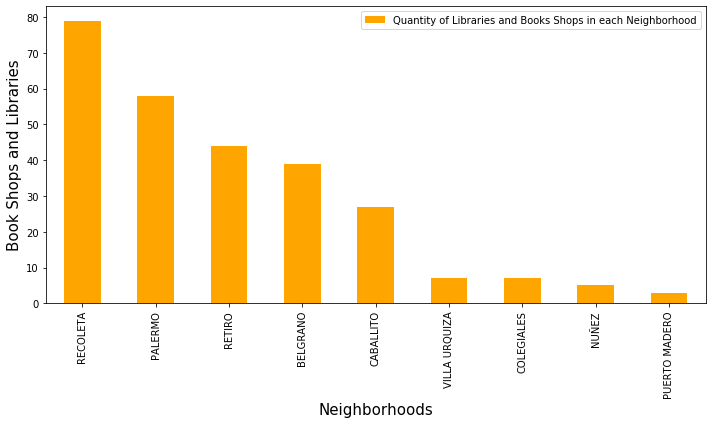

In [31]:
ax = bks.plot(kind='bar', x='Neighborhood', y='count', figsize=(10,6), color='Orange')
ax.legend(["Quantity of Libraries and Books Shops in each Neighborhood"]);
ax.set_ylabel("Book Shops and Libraries",fontsize = 15)
ax.set_xlabel("Neighborhoods",fontsize = 15)
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("Books.png")

Buenos Aires is one of the cities that has more theaters in the world, almost comparable to New York or Paris. Let's see which of our candidate neighborhoods have Theaters, Cinemas, Performing Arts Spaces such as Dance and Music to see which are the neighborhoods with potential to open a venue. 
We know that behind each theater or cinema there is a wait, either to meet someone before entering or to kill time to enter. Opening a place near cinemas, theaters and cultural spaces can be a good opportunity to sell the product.

In [32]:
cat = ["SCENICAL SPACE (THEATER, MUSIC AND DANCE)", "TV", "AUDIOVISUAL PRODUCTION"]
tv_theaters = df_cult[df_cult['Neighborhood'].isin(neighborhoods)]
tv_theaters = tv_theaters[tv_theaters['Category'].isin(cat)].groupby('Neighborhood', as_index=False).count().sort_values('Name', ascending=False)
tv_theaters.rename(columns={'Category': 'Count'}, inplace=True)
tv_theaters



Neighborhood  Name  Count  LAT  LNG
3        PALERMO    12     12   12   12
2          NUÑEZ     5      5    5    5
1     COLEGIALES     4      4    4    4
4       RECOLETA     4      4    4    4
0       BELGRANO     2      2    2    2
5         RETIRO     2      2    2    2
6  VILLA URQUIZA     1      1    1    1

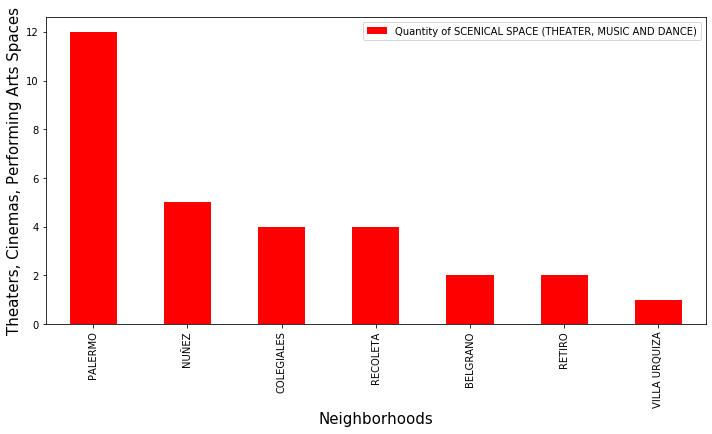

In [33]:
ax = tv_theaters.plot(kind='bar', x='Neighborhood', y='Count', figsize=(10,6), color='Red')
ax.legend(["Quantity of SCENICAL SPACE (THEATER, MUSIC AND DANCE)", "TV", "AUDIOVISUAL PRODUCTION in each Neighborhood"]);
fig = ax.get_figure()
ax.set_ylabel("Theaters, Cinemas, Performing Arts Spaces",fontsize = 15)
ax.set_xlabel("Neighborhoods",fontsize = 15)
fig.tight_layout()
fig.savefig("tv.png")


We see that Palermo, by far is the neighborhood that has more in this category

As we mentioned, our public likes art. We are going to look for Art Galleries to see where they are

In [34]:
galleries = df_cult[df_cult['Category'] ==  'ART GALLERY']
galleries = galleries[galleries['Neighborhood'].isin(neighborhoods)]
galleries.rename(columns={'Category': 'Count'}, inplace=True)
galleries = galleries.groupby('Neighborhood', as_index=False).count().sort_values('Count', ascending=False)
galleries


Neighborhood  Name  Count  LAT  LNG
2         RETIRO    27     27   27   27
0        PALERMO    14     14   14   14
1       RECOLETA    11     11   11   11
3  VILLA URQUIZA     1      1    1    1

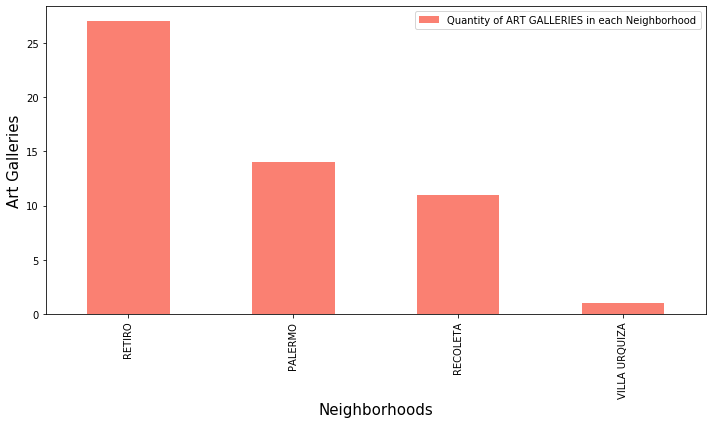

In [35]:
ax = galleries.plot(kind='bar', x='Neighborhood', y='Count', figsize=(10,6), color='Salmon')
ax.legend(["Quantity of ART GALLERIES in each Neighborhood"]);
fig = ax.get_figure()
ax.set_ylabel("Art Galleries",fontsize = 15)
ax.set_xlabel("Neighborhoods",fontsize = 15)
fig.tight_layout()
fig.savefig("art.png")

Retiro is by far the neighborhood that has more in this category

We do the same with Cultural Centers

In [36]:
cult_centers = df_cult[df_cult['Category'] ==  'CULTURAL CENTER']
cult_centers = cult_centers[cult_centers['Neighborhood'].isin(neighborhoods)]
cult_centers.rename(columns={'Category': 'Count'}, inplace=True)
cult_centers = cult_centers.groupby('Neighborhood', as_index=False).count().sort_values('Count', ascending=False)
cult_centers



Neighborhood  Name  Count  LAT  LNG
4        PALERMO    10     10   10   10
1      CABALLITO     5      5    5    5
3          NUÑEZ     3      3    3    3
6       RECOLETA     3      3    3    3
7         RETIRO     3      3    3    3
8  VILLA URQUIZA     3      3    3    3
0       BELGRANO     2      2    2    2
2     COLEGIALES     1      1    1    1
5  PUERTO MADERO     1      1    1    1

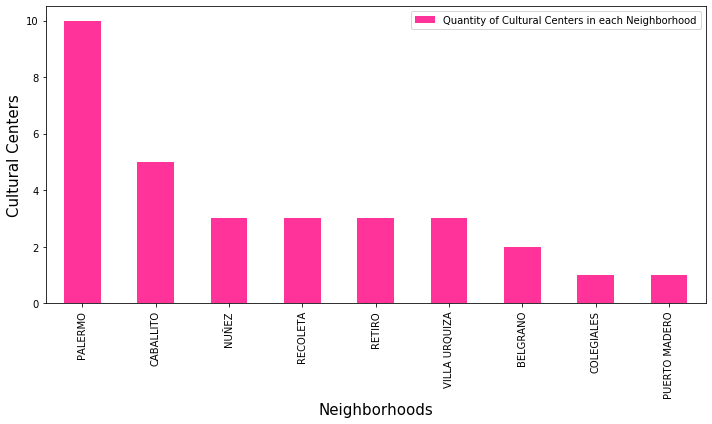

In [37]:
ax = cult_centers.plot(kind='bar', x='Neighborhood', y='Count', figsize=(10,6), color='#FF3399')
ax.legend(["Quantity of Cultural Centers in each Neighborhood"]);
fig = ax.get_figure()
ax.set_ylabel("Cultural Centers",fontsize = 15)
ax.set_xlabel("Neighborhoods",fontsize = 15)
fig.tight_layout()
fig.savefig("cultural_centers.png")

Palermo is the neighborhood with more Cultural Centers

And with Universities

In [38]:
#Get information of Universities in BA
url_uni = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/universidades/universidades.csv'
df_uni = pd.read_csv(url_uni)
df_uni.head()


regimen                                         universida  univ_c  \
0  Privado  FLACSO (Facultad Latinoamericana de Ciencias S...       1   
1  Privado              Instituto Tecnológico de Buenos Aires       2   
2  Privado              Instituto Tecnológico de Buenos Aires       2   
3  Privado              Instituto Tecnológico de Buenos Aires       2   
4  Privado              Instituto Tecnológico de Buenos Aires       2   

                      unidad_aca  unac_c  anexo_c  unicue   cui  \
0                      Rectorado       1        0  100100  2546   
1                      Rectorado       1        0  200100  2456   
2  Departamento de Investigación       7        0  200700  2456   
3                Área de Energía      40        0  204000  2456   
4  Departamento de Bioingeniería      87        0  208700  2456   

                    telef        fax  ...          direccion_norm  \
0  5238-9339 (C)5238-9300  4375-1373  ...            Ayacucho 555   
1   63934813 [C]6393-4810  6393-4813  ...  Av. Eduardo Madero 399   
2               6393-4869  6393-4869  ...  Av. Eduardo Madero 399   
3               6393-4870  6393-4870  ...  Av. Eduardo Madero 399   
4               6393-4893  6393-4893  ...  Av. Eduardo Madero 399   

                 calle altura                                     WKT_gkba  \
0            Ayacucho     555  POINT (-58.3953412190814 -34.6026584750106)   
1  Av. Eduardo Madero     399  POINT (-58.3678488464698 -34.6031162314776)   
2  Av. Eduardo Madero     399  POINT (-58.3678488464698 -34.6031162314776)   
3  Av. Eduardo Madero     399  POINT (-58.3678488464698 -34.6031162314776)   
4  Av. Eduardo Madero     399  POINT (-58.3678488464698 -34.6031162314776)   

          barrio    comuna codigo_postal  codigo_postal_argentino       long  \
0      Balvanera  Comuna 3        1026.0                 C1026AAC -58.395341   
1  Puerto Madero  Comuna 1        1106.0                 C1106ACD -58.367849   
2  Puerto Madero  Comuna 1        1106.0                 C1106ACD -58.367849   
3  Puerto Madero  Comuna 1        1106.0                 C1106ACD -58.367849   
4  Puerto Madero  Comuna 1        1106.0                 C1106ACD -58.367849   

         lat  
0 -34.602658  
1 -34.603116  
2 -34.603116  
3 -34.603116  
4 -34.603116  

[5 rows x 21 columns]

We filter the Dataframe to keep the columns in what we are interested

In [39]:
df_uni = df_uni[['barrio','universida', 'lat','long']]
df_uni

barrio                                         universida  \
0        Balvanera  FLACSO (Facultad Latinoamericana de Ciencias S...   
1    Puerto Madero              Instituto Tecnológico de Buenos Aires   
2    Puerto Madero              Instituto Tecnológico de Buenos Aires   
3    Puerto Madero              Instituto Tecnológico de Buenos Aires   
4    Puerto Madero              Instituto Tecnológico de Buenos Aires   
..             ...                                                ...   
388       Belgrano                      Universidad Torcuato Di Tella   
389       Belgrano                      Universidad Torcuato Di Tella   
390       Belgrano                      Universidad Torcuato Di Tella   
391       Belgrano                      Universidad Torcuato Di Tella   
392         Retiro                  Universitá Degli Studi di Bologna   

           lat       long  
0   -34.602658 -58.395341  
1   -34.603116 -58.367849  
2   -34.603116 -58.367849  
3   -34.603116 -58.367849  
4   -34.603116 -58.367849  
..         ...        ...  
388 -34.548197 -58.447392  
389 -34.548197 -58.447392  
390 -34.548197 -58.447392  
391 -34.548197 -58.447392  
392 -34.596759 -58.383562  

[393 rows x 4 columns]

There are 393 Universities in Buenos Aires

English Translation and Data Wrangling

In [40]:
df_uni.rename(columns={"universida": "Name", "barrio": "Neighborhood"}, inplace=True)
df_uni["Neighborhood"] = df_uni["Neighborhood"].str.upper()
df_uni

Neighborhood                                               Name  \
0        BALVANERA  FLACSO (Facultad Latinoamericana de Ciencias S...   
1    PUERTO MADERO              Instituto Tecnológico de Buenos Aires   
2    PUERTO MADERO              Instituto Tecnológico de Buenos Aires   
3    PUERTO MADERO              Instituto Tecnológico de Buenos Aires   
4    PUERTO MADERO              Instituto Tecnológico de Buenos Aires   
..             ...                                                ...   
388       BELGRANO                      Universidad Torcuato Di Tella   
389       BELGRANO                      Universidad Torcuato Di Tella   
390       BELGRANO                      Universidad Torcuato Di Tella   
391       BELGRANO                      Universidad Torcuato Di Tella   
392         RETIRO                  Universitá Degli Studi di Bologna   

           lat       long  
0   -34.602658 -58.395341  
1   -34.603116 -58.367849  
2   -34.603116 -58.367849  
3   -34.603116 -58.367849  
4   -34.603116 -58.367849  
..         ...        ...  
388 -34.548197 -58.447392  
389 -34.548197 -58.447392  
390 -34.548197 -58.447392  
391 -34.548197 -58.447392  
392 -34.596759 -58.383562  

[393 rows x 4 columns]

Filter, Count and Sort Universities by Candidate Neighboorhod

In [41]:
df_uni.rename(columns={"Name": "count"}, inplace=True)
df_uni = df_uni[df_uni['Neighborhood'].isin(neighborhoods)]
df_uni = df_uni.groupby(['Neighborhood'], as_index=False).count().sort_values('count',ascending=False)

df_uni

Neighborhood  count  lat  long
4  PUERTO MADERO     39   39    39
3        PALERMO     31   31    31
5       RECOLETA     27   27    27
1      CABALLITO     25   25    25
6         RETIRO     24   24    24
0       BELGRANO     18   18    18
7  VILLA URQUIZA      2    2     2
2     COLEGIALES      1    1     1

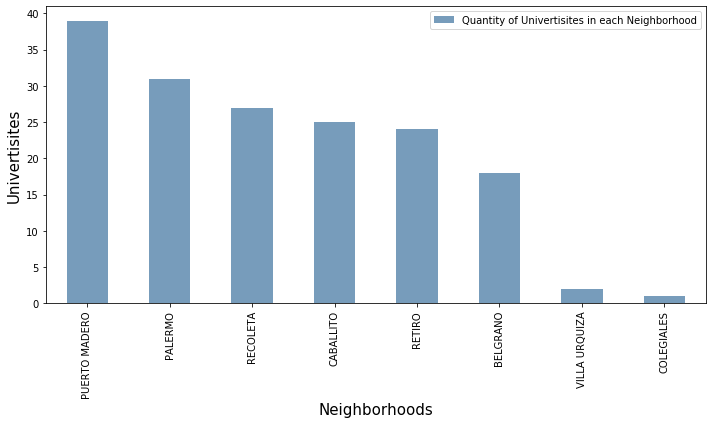

In [42]:
ax = df_uni.plot(kind='bar', x='Neighborhood', y='count', figsize=(10,6), color='#779CBB')
ax.legend(["Quantity of Univertisites in each Neighborhood"]);
fig = ax.get_figure()
ax.set_ylabel("Univertisites",fontsize = 15)
ax.set_xlabel("Neighborhoods",fontsize = 15)
fig.tight_layout()
fig.savefig("uni.png")

Puerto Madero is the neighborhood that has more universities, followed by Palermo

Now we are going to use the Foursquare Api to analyze about the category of the place that we are going to open: Cafeteria.

API Setup

In [43]:
#Foursquare API config
CLIENT_ID = 'KUE4RZE5CCZ0KWCQB05TQV3QNH1A2HTVEDMPQA1QK2C3OFGI' # your Foursquare ID
CLIENT_SECRET = 'ZAZXW102JLI2B1NLURTFLN3IV4A5MSVWZ3X3M0D4BMUQPKUR' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KUE4RZE5CCZ0KWCQB05TQV3QNH1A2HTVEDMPQA1QK2C3OFGI
CLIENT_SECRET:ZAZXW102JLI2B1NLURTFLN3IV4A5MSVWZ3X3M0D4BMUQPKUR


I defined a function to obtain the information of the venues, with a limit of 500 and a radius of 5000 meters

In [44]:
def get_venues(name, latitudes, longitudes, radius=5000):
    LIMIT = 500
    venues_list=[]
    for name, lat, lng in zip(name, latitudes, longitudes):
        print("Retrieving venues of",name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #Information for each venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue','id',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(venues)

Let's see the venues of each of our candidate neighborhoods

In [45]:
ba_venues = get_venues(name=top_ten['Neighborhood'],
                                   latitudes=top_ten['lat'],
                                   longitudes=top_ten['lon']
                                  )

Retrieving venues of PUERTO MADERO
Retrieving venues of RECOLETA
Retrieving venues of PALERMO
Retrieving venues of BELGRANO
Retrieving venues of NUÑEZ
Retrieving venues of COLEGIALES
Retrieving venues of VILLA URQUIZA
Retrieving venues of COGHLAN
Retrieving venues of RETIRO
Retrieving venues of CABALLITO


We save the information in a csv file

In [46]:
ba_venues.to_csv("ba_venues.csv")

We have 1000 results of Foursquare API

In [47]:
ba_venues.shape

(1000, 8)

In [48]:
ba_venues

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    PUERTO MADERO             -34.610376              -58.362207   
1    PUERTO MADERO             -34.610376              -58.362207   
2    PUERTO MADERO             -34.610376              -58.362207   
3    PUERTO MADERO             -34.610376              -58.362207   
4    PUERTO MADERO             -34.610376              -58.362207   
..             ...                    ...                     ...   
995      CABALLITO             -34.620077              -58.442489   
996      CABALLITO             -34.620077              -58.442489   
997      CABALLITO             -34.620077              -58.442489   
998      CABALLITO             -34.620077              -58.442489   
999      CABALLITO             -34.620077              -58.442489   

                        Venue                        id  Venue Latitude  \
0                 Alvear Icon  5537bcb2498ee4b97e749228      -34.610553   
1                       Osaka  4fb85050e4b0698549a8fa68      -34.611101   
2    Faena Hotel Buenos Aires  53548b1b498e9e43090e33f4      -34.613737   
3                       Chila  4bef430ef2712d7fae8ffbd8      -34.611016   
4                 Crystal Bar  5a19c9fb6e465009cd242f60      -34.610559   
..                        ...                       ...             ...   
995               Always Club  4b56e015f964a520c11d28e3      -34.586514   
996     Roll'in Luí Alimentos  5723fce6498e66056ae75b54      -34.584608   
997                    Crêpas  54262037498e58df0897e5e1      -34.588178   
998         Le Pain Quotidien  51250e48e4b09cd3d3125918      -34.589813   
999           Schwartz & Berg  566a2824498e2a38e51872ca      -34.584833   

     Venue Longitude                 Venue Category  
0         -58.361741                          Hotel  
1         -58.362423            Japanese Restaurant  
2         -58.361987                          Hotel  
3         -58.366110         Argentinian Restaurant  
4         -58.361657                      Hotel Bar  
..               ...                            ...  
995       -58.423993           Gym / Fitness Center  
996       -58.449495  Vegetarian / Vegan Restaurant  
997       -58.427354                       Creperie  
998       -58.427727                         Bakery  
999       -58.436989                  Deli / Bodega  

[1000 rows x 8 columns]

Grouped by neighborhood

In [49]:
ba_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue   id  \
Neighborhood                                                               
BELGRANO                         100                     100    100  100   
CABALLITO                        100                     100    100  100   
COGHLAN                          100                     100    100  100   
COLEGIALES                       100                     100    100  100   
NUÑEZ                            100                     100    100  100   
PALERMO                          100                     100    100  100   
PUERTO MADERO                    100                     100    100  100   
RECOLETA                         100                     100    100  100   
RETIRO                           100                     100    100  100   
VILLA URQUIZA                    100                     100    100  100   

               Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                    
BELGRANO                  100              100             100  
CABALLITO                 100              100             100  
COGHLAN                   100              100             100  
COLEGIALES                100              100             100  
NUÑEZ                     100              100             100  
PALERMO                   100              100             100  
PUERTO MADERO             100              100             100  
RECOLETA                  100              100             100  
RETIRO                    100              100             100  
VILLA URQUIZA             100              100             100

Let's see how many of these venues are Coffe Shops, the category in which we are interested in opening one venue

In [50]:
coffees = ba_venues[ba_venues['Venue Category'] == 'Coffee Shop']
coffees

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
13   PUERTO MADERO             -34.610376              -58.362207   
58   PUERTO MADERO             -34.610376              -58.362207   
60   PUERTO MADERO             -34.610376              -58.362207   
70   PUERTO MADERO             -34.610376              -58.362207   
80   PUERTO MADERO             -34.610376              -58.362207   
84   PUERTO MADERO             -34.610376              -58.362207   
97   PUERTO MADERO             -34.610376              -58.362207   
119       RECOLETA             -34.587358              -58.391570   
139       RECOLETA             -34.587358              -58.391570   
149       RECOLETA             -34.587358              -58.391570   
168       RECOLETA             -34.587358              -58.391570   
175       RECOLETA             -34.587358              -58.391570   
179       RECOLETA             -34.587358              -58.391570   
190       RECOLETA             -34.587358              -58.391570   
216        PALERMO             -34.580336              -58.424524   
253        PALERMO             -34.580336              -58.424524   
256        PALERMO             -34.580336              -58.424524   
301       BELGRANO             -34.561308              -58.456545   
304       BELGRANO             -34.561308              -58.456545   
346       BELGRANO             -34.561308              -58.456545   
393       BELGRANO             -34.561308              -58.456545   
394       BELGRANO             -34.561308              -58.456545   
424          NUÑEZ             -34.545348              -58.462149   
429          NUÑEZ             -34.545348              -58.462149   
451          NUÑEZ             -34.545348              -58.462149   
478          NUÑEZ             -34.545348              -58.462149   
516     COLEGIALES             -34.574515              -58.452282   
536     COLEGIALES             -34.574515              -58.452282   
552     COLEGIALES             -34.574515              -58.452282   
553     COLEGIALES             -34.574515              -58.452282   
570     COLEGIALES             -34.574515              -58.452282   
574     COLEGIALES             -34.574515              -58.452282   
605  VILLA URQUIZA             -34.573241              -58.491478   
621  VILLA URQUIZA             -34.573241              -58.491478   
645  VILLA URQUIZA             -34.573241              -58.491478   
651  VILLA URQUIZA             -34.573241              -58.491478   
656  VILLA URQUIZA             -34.573241              -58.491478   
704        COGHLAN             -34.559910              -58.474714   
707        COGHLAN             -34.559910              -58.474714   
716        COGHLAN             -34.559910              -58.474714   
739        COGHLAN             -34.559910              -58.474714   
747        COGHLAN             -34.559910              -58.474714   
788        COGHLAN             -34.559910              -58.474714   
805         RETIRO             -34.591643              -58.373307   
807         RETIRO             -34.591643              -58.373307   
815         RETIRO             -34.591643              -58.373307   
833         RETIRO             -34.591643              -58.373307   
850         RETIRO             -34.591643              -58.373307   
853         RETIRO             -34.591643              -58.373307   
876         RETIRO             -34.591643              -58.373307   
882         RETIRO             -34.591643              -58.373307   
887         RETIRO             -34.591643              -58.373307   
936      CABALLITO             -34.620077              -58.442489   
982      CABALLITO             -34.620077              -58.442489   

                                   Venue                        id  \
13             Ol'days (Coffee and Deli)  559053ea498e40e260853343   
58                             Starbucks  4cc11a9aaa5776b057bd7544   


In [51]:
coffees.count()

Neighborhood              54
Neighborhood Latitude     54
Neighborhood Longitude    54
Venue                     54
id                        54
Venue Latitude            54
Venue Longitude           54
Venue Category            54
dtype: int64

We have 54 Coffee Shops registered on Foursquare

Coffee Shops grouped by neighborhood

In [52]:
coffees = coffees.groupby('Neighborhood', as_index=False).count()
coffees

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  Venue  id  \
0       BELGRANO                      5                       5      5   5   
1      CABALLITO                      2                       2      2   2   
2        COGHLAN                      6                       6      6   6   
3     COLEGIALES                      6                       6      6   6   
4          NUÑEZ                      4                       4      4   4   
5        PALERMO                      3                       3      3   3   
6  PUERTO MADERO                      7                       7      7   7   
7       RECOLETA                      7                       7      7   7   
8         RETIRO                      9                       9      9   9   
9  VILLA URQUIZA                      5                       5      5   5   

   Venue Latitude  Venue Longitude  Venue Category  
0               5                5               5  
1               2                2               2  
2               6                6               6  
3               6                6               6  
4               4                4               4  
5               3                3               3  
6               7                7               7  
7               7                7               7  
8               9                9               9  
9               5                5               5

Rename columns

In [53]:
coffees.rename(columns={'Neighborhood Latitude': 'lat','Neighborhood Longitude': 'long'}, inplace=True) # 'Venue', 'id', 'Venue Latitude','Venue Longitude'], inplace=True)

Count Coffee Shops by neighborhood

In [54]:
coffees.rename(columns={"Venue Category": "Count"}, inplace=True)
coffees = coffees.sort_values("Count", ascending=False)
coffees

Neighborhood  lat  long  Venue  id  Venue Latitude  Venue Longitude  Count
8         RETIRO    9     9      9   9               9                9      9
6  PUERTO MADERO    7     7      7   7               7                7      7
7       RECOLETA    7     7      7   7               7                7      7
2        COGHLAN    6     6      6   6               6                6      6
3     COLEGIALES    6     6      6   6               6                6      6
0       BELGRANO    5     5      5   5               5                5      5
9  VILLA URQUIZA    5     5      5   5               5                5      5
4          NUÑEZ    4     4      4   4               4                4      4
5        PALERMO    3     3      3   3               3                3      3
1      CABALLITO    2     2      2   2               2                2      2

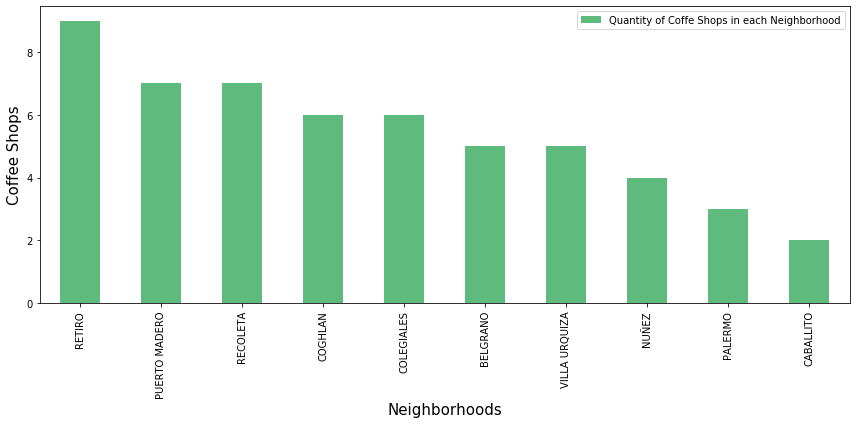

In [55]:
ax = coffees.plot(kind='bar', x='Neighborhood', y='Count', figsize=(12,6), color='#5EBA7D')
ax.legend(["Quantity of Coffe Shops in each Neighborhood"]);
fig = ax.get_figure()
ax.set_ylabel("Coffee Shops",fontsize = 15)
ax.set_xlabel("Neighborhoods",fontsize = 15)
fig.tight_layout()
fig.savefig("coffe.png")

Let's see on a map choropleth the quantity of Coffee Shops in Buenos Aires

In [56]:
coffee_map = folium.Map(location=[ba_center[0], ba_center[1]], zoom_start=12)

coffee_map.choropleth(
    geo_data=ba_geo,
    data=coffees,
    columns=['Neighborhood', 'Count'],
    key_on='feature.properties.barrio',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name="Coffee Shops per Neigborhood"
)
# display map
coffee_map.save('coffe_map.html')
coffee_map

In [57]:
shops = ba_venues[ba_venues['Venue Category'] == 'Coffee Shop']
shops

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
13   PUERTO MADERO             -34.610376              -58.362207   
58   PUERTO MADERO             -34.610376              -58.362207   
60   PUERTO MADERO             -34.610376              -58.362207   
70   PUERTO MADERO             -34.610376              -58.362207   
80   PUERTO MADERO             -34.610376              -58.362207   
84   PUERTO MADERO             -34.610376              -58.362207   
97   PUERTO MADERO             -34.610376              -58.362207   
119       RECOLETA             -34.587358              -58.391570   
139       RECOLETA             -34.587358              -58.391570   
149       RECOLETA             -34.587358              -58.391570   
168       RECOLETA             -34.587358              -58.391570   
175       RECOLETA             -34.587358              -58.391570   
179       RECOLETA             -34.587358              -58.391570   
190       RECOLETA             -34.587358              -58.391570   
216        PALERMO             -34.580336              -58.424524   
253        PALERMO             -34.580336              -58.424524   
256        PALERMO             -34.580336              -58.424524   
301       BELGRANO             -34.561308              -58.456545   
304       BELGRANO             -34.561308              -58.456545   
346       BELGRANO             -34.561308              -58.456545   
393       BELGRANO             -34.561308              -58.456545   
394       BELGRANO             -34.561308              -58.456545   
424          NUÑEZ             -34.545348              -58.462149   
429          NUÑEZ             -34.545348              -58.462149   
451          NUÑEZ             -34.545348              -58.462149   
478          NUÑEZ             -34.545348              -58.462149   
516     COLEGIALES             -34.574515              -58.452282   
536     COLEGIALES             -34.574515              -58.452282   
552     COLEGIALES             -34.574515              -58.452282   
553     COLEGIALES             -34.574515              -58.452282   
570     COLEGIALES             -34.574515              -58.452282   
574     COLEGIALES             -34.574515              -58.452282   
605  VILLA URQUIZA             -34.573241              -58.491478   
621  VILLA URQUIZA             -34.573241              -58.491478   
645  VILLA URQUIZA             -34.573241              -58.491478   
651  VILLA URQUIZA             -34.573241              -58.491478   
656  VILLA URQUIZA             -34.573241              -58.491478   
704        COGHLAN             -34.559910              -58.474714   
707        COGHLAN             -34.559910              -58.474714   
716        COGHLAN             -34.559910              -58.474714   
739        COGHLAN             -34.559910              -58.474714   
747        COGHLAN             -34.559910              -58.474714   
788        COGHLAN             -34.559910              -58.474714   
805         RETIRO             -34.591643              -58.373307   
807         RETIRO             -34.591643              -58.373307   
815         RETIRO             -34.591643              -58.373307   
833         RETIRO             -34.591643              -58.373307   
850         RETIRO             -34.591643              -58.373307   
853         RETIRO             -34.591643              -58.373307   
876         RETIRO             -34.591643              -58.373307   
882         RETIRO             -34.591643              -58.373307   
887         RETIRO             -34.591643              -58.373307   
936      CABALLITO             -34.620077              -58.442489   
982      CABALLITO             -34.620077              -58.442489   

                                   Venue                        id  \
13             Ol'days (Coffee and Deli)  559053ea498e40e260853343   
58                             Starbucks  4cc11a9aaa5776b057bd7544   


We will merge and place all the data in a single dataframe to have all the unified information in one place

In [58]:
res = pd.merge(top_ten,bks, on='Neighborhood', how='outer')
res.rename(columns={"count": "Bookshops"}, inplace=True)
res

Neighborhood        lat        lon    avg_price  Bookshops
0  PUERTO MADERO -34.610376 -58.362207  6030.571429        3.0
1       RECOLETA -34.587358 -58.391570  3751.450000       79.0
2        PALERMO -34.580336 -58.424524  3708.200000       58.0
3       BELGRANO -34.561308 -58.456545  3637.375000       39.0
4          NUÑEZ -34.545348 -58.462149  3515.777778        5.0
5     COLEGIALES -34.574515 -58.452282  3302.294118        7.0
6  VILLA URQUIZA -34.573241 -58.491478  3127.575000        7.0
7        COGHLAN -34.559910 -58.474714  3091.352941        NaN
8         RETIRO -34.591643 -58.373307  3010.300000       44.0
9      CABALLITO -34.620077 -58.442489  2925.300000       27.0

Merge of the cinema, theater and TV dataframe

In [59]:
res = pd.merge(res,tv_theaters, on='Neighborhood', how='outer')
res

Neighborhood        lat        lon    avg_price  Bookshops  Name  Count  \
0  PUERTO MADERO -34.610376 -58.362207  6030.571429        3.0   NaN    NaN   
1       RECOLETA -34.587358 -58.391570  3751.450000       79.0   4.0    4.0   
2        PALERMO -34.580336 -58.424524  3708.200000       58.0  12.0   12.0   
3       BELGRANO -34.561308 -58.456545  3637.375000       39.0   2.0    2.0   
4          NUÑEZ -34.545348 -58.462149  3515.777778        5.0   5.0    5.0   
5     COLEGIALES -34.574515 -58.452282  3302.294118        7.0   4.0    4.0   
6  VILLA URQUIZA -34.573241 -58.491478  3127.575000        7.0   1.0    1.0   
7        COGHLAN -34.559910 -58.474714  3091.352941        NaN   NaN    NaN   
8         RETIRO -34.591643 -58.373307  3010.300000       44.0   2.0    2.0   
9      CABALLITO -34.620077 -58.442489  2925.300000       27.0   NaN    NaN   

    LAT   LNG  
0   NaN   NaN  
1   4.0   4.0  
2  12.0  12.0  
3   2.0   2.0  
4   5.0   5.0  
5   4.0   4.0  
6   1.0   1.0  
7   NaN   NaN  
8   2.0   2.0  
9   NaN   NaN

Rename columns

In [60]:
res.drop(columns=["Name", "LAT", "LNG"], inplace=True)
res.rename(columns={"Count": "TV-Studios"}, inplace=True)
res

Neighborhood        lat        lon    avg_price  Bookshops  TV-Studios
0  PUERTO MADERO -34.610376 -58.362207  6030.571429        3.0         NaN
1       RECOLETA -34.587358 -58.391570  3751.450000       79.0         4.0
2        PALERMO -34.580336 -58.424524  3708.200000       58.0        12.0
3       BELGRANO -34.561308 -58.456545  3637.375000       39.0         2.0
4          NUÑEZ -34.545348 -58.462149  3515.777778        5.0         5.0
5     COLEGIALES -34.574515 -58.452282  3302.294118        7.0         4.0
6  VILLA URQUIZA -34.573241 -58.491478  3127.575000        7.0         1.0
7        COGHLAN -34.559910 -58.474714  3091.352941        NaN         NaN
8         RETIRO -34.591643 -58.373307  3010.300000       44.0         2.0
9      CABALLITO -34.620077 -58.442489  2925.300000       27.0         NaN

Merge of the Galleries dataframe and rename columns

In [61]:
res = pd.merge(res,galleries, on='Neighborhood', how='outer')
res.drop(columns=["Name", "LAT", "LNG"], inplace=True)
res.rename(columns={"Count": "Galleries"}, inplace=True)
res

Neighborhood        lat        lon    avg_price  Bookshops  TV-Studios  \
0  PUERTO MADERO -34.610376 -58.362207  6030.571429        3.0         NaN   
1       RECOLETA -34.587358 -58.391570  3751.450000       79.0         4.0   
2        PALERMO -34.580336 -58.424524  3708.200000       58.0        12.0   
3       BELGRANO -34.561308 -58.456545  3637.375000       39.0         2.0   
4          NUÑEZ -34.545348 -58.462149  3515.777778        5.0         5.0   
5     COLEGIALES -34.574515 -58.452282  3302.294118        7.0         4.0   
6  VILLA URQUIZA -34.573241 -58.491478  3127.575000        7.0         1.0   
7        COGHLAN -34.559910 -58.474714  3091.352941        NaN         NaN   
8         RETIRO -34.591643 -58.373307  3010.300000       44.0         2.0   
9      CABALLITO -34.620077 -58.442489  2925.300000       27.0         NaN   

   Galleries  
0        NaN  
1       11.0  
2       14.0  
3        NaN  
4        NaN  
5        NaN  
6        1.0  
7        NaN  
8       27.0  
9        NaN

Merge of the Cultural Centers dataframe and rename columns

In [62]:
res = pd.merge(res,cult_centers, on='Neighborhood', how='outer')
res.drop(columns=["Name", "LAT", "LNG"], inplace=True)
res.rename(columns={"Count": "Cultural Centers"}, inplace=True)
res

Neighborhood        lat        lon    avg_price  Bookshops  TV-Studios  \
0  PUERTO MADERO -34.610376 -58.362207  6030.571429        3.0         NaN   
1       RECOLETA -34.587358 -58.391570  3751.450000       79.0         4.0   
2        PALERMO -34.580336 -58.424524  3708.200000       58.0        12.0   
3       BELGRANO -34.561308 -58.456545  3637.375000       39.0         2.0   
4          NUÑEZ -34.545348 -58.462149  3515.777778        5.0         5.0   
5     COLEGIALES -34.574515 -58.452282  3302.294118        7.0         4.0   
6  VILLA URQUIZA -34.573241 -58.491478  3127.575000        7.0         1.0   
7        COGHLAN -34.559910 -58.474714  3091.352941        NaN         NaN   
8         RETIRO -34.591643 -58.373307  3010.300000       44.0         2.0   
9      CABALLITO -34.620077 -58.442489  2925.300000       27.0         NaN   

   Galleries  Cultural Centers  
0        NaN               1.0  
1       11.0               3.0  
2       14.0              10.0  
3        NaN               2.0  
4        NaN               3.0  
5        NaN               1.0  
6        1.0               3.0  
7        NaN               NaN  
8       27.0               3.0  
9        NaN               5.0

Merge of the Universities dataframe and rename columns

In [63]:
res = pd.merge(res,df_uni, on='Neighborhood', how='outer')
res.rename(columns={"count": "Univerisites", "lat_x": "lat" }, inplace=True)
res

Neighborhood        lat        lon    avg_price  Bookshops  TV-Studios  \
0  PUERTO MADERO -34.610376 -58.362207  6030.571429        3.0         NaN   
1       RECOLETA -34.587358 -58.391570  3751.450000       79.0         4.0   
2        PALERMO -34.580336 -58.424524  3708.200000       58.0        12.0   
3       BELGRANO -34.561308 -58.456545  3637.375000       39.0         2.0   
4          NUÑEZ -34.545348 -58.462149  3515.777778        5.0         5.0   
5     COLEGIALES -34.574515 -58.452282  3302.294118        7.0         4.0   
6  VILLA URQUIZA -34.573241 -58.491478  3127.575000        7.0         1.0   
7        COGHLAN -34.559910 -58.474714  3091.352941        NaN         NaN   
8         RETIRO -34.591643 -58.373307  3010.300000       44.0         2.0   
9      CABALLITO -34.620077 -58.442489  2925.300000       27.0         NaN   

   Galleries  Cultural Centers  Univerisites  lat_y  long  
0        NaN               1.0          39.0   39.0  39.0  
1       11.0               3.0          27.0   27.0  27.0  
2       14.0              10.0          31.0   31.0  31.0  
3        NaN               2.0          18.0   18.0  18.0  
4        NaN               3.0           NaN    NaN   NaN  
5        NaN               1.0           1.0    1.0   1.0  
6        1.0               3.0           2.0    2.0   2.0  
7        NaN               NaN           NaN    NaN   NaN  
8       27.0               3.0          24.0   24.0  24.0  
9        NaN               5.0          25.0   25.0  25.0

In [64]:
res.drop(columns=['lat_y','long'], inplace=True)
res.replace(np.nan, 0, inplace=True)
res

Neighborhood        lat        lon    avg_price  Bookshops  TV-Studios  \
0  PUERTO MADERO -34.610376 -58.362207  6030.571429        3.0         0.0   
1       RECOLETA -34.587358 -58.391570  3751.450000       79.0         4.0   
2        PALERMO -34.580336 -58.424524  3708.200000       58.0        12.0   
3       BELGRANO -34.561308 -58.456545  3637.375000       39.0         2.0   
4          NUÑEZ -34.545348 -58.462149  3515.777778        5.0         5.0   
5     COLEGIALES -34.574515 -58.452282  3302.294118        7.0         4.0   
6  VILLA URQUIZA -34.573241 -58.491478  3127.575000        7.0         1.0   
7        COGHLAN -34.559910 -58.474714  3091.352941        0.0         0.0   
8         RETIRO -34.591643 -58.373307  3010.300000       44.0         2.0   
9      CABALLITO -34.620077 -58.442489  2925.300000       27.0         0.0   

   Galleries  Cultural Centers  Univerisites  
0        0.0               1.0          39.0  
1       11.0               3.0          27.0  
2       14.0              10.0          31.0  
3        0.0               2.0          18.0  
4        0.0               3.0           0.0  
5        0.0               1.0           1.0  
6        1.0               3.0           2.0  
7        0.0               0.0           0.0  
8       27.0               3.0          24.0  
9        0.0               5.0          25.0

Merge of the Coffee Shops Dataframe from Foursquare and Rename columns

Now we get all the information in one single dataframe

In [65]:
res = pd.merge(res,coffees, on='Neighborhood', how='outer')
res.rename(columns={"Count": "Coffee-Shops", "lat_x": "lat"}, inplace=True)
res.drop(columns=["lat_y","long","Venue","id","Venue Latitude","Venue Longitude"], inplace=True)
res

Neighborhood        lat        lon    avg_price  Bookshops  TV-Studios  \
0  PUERTO MADERO -34.610376 -58.362207  6030.571429        3.0         0.0   
1       RECOLETA -34.587358 -58.391570  3751.450000       79.0         4.0   
2        PALERMO -34.580336 -58.424524  3708.200000       58.0        12.0   
3       BELGRANO -34.561308 -58.456545  3637.375000       39.0         2.0   
4          NUÑEZ -34.545348 -58.462149  3515.777778        5.0         5.0   
5     COLEGIALES -34.574515 -58.452282  3302.294118        7.0         4.0   
6  VILLA URQUIZA -34.573241 -58.491478  3127.575000        7.0         1.0   
7        COGHLAN -34.559910 -58.474714  3091.352941        0.0         0.0   
8         RETIRO -34.591643 -58.373307  3010.300000       44.0         2.0   
9      CABALLITO -34.620077 -58.442489  2925.300000       27.0         0.0   

   Galleries  Cultural Centers  Univerisites  Coffee-Shops  
0        0.0               1.0          39.0             7  
1       11.0               3.0          27.0             7  
2       14.0              10.0          31.0             3  
3        0.0               2.0          18.0             5  
4        0.0               3.0           0.0             4  
5        0.0               1.0           1.0             6  
6        1.0               3.0           2.0             5  
7        0.0               0.0           0.0             6  
8       27.0               3.0          24.0             9  
9        0.0               5.0          25.0             2

We import the libraries needed to graph

In [66]:
import seaborn as sns
import numpy as np
from sklearn import preprocessing

We define the features to represent in the graph

In [67]:
features=np.array(['Bookshops','TV-Studios','Galleries','Cultural Centers','Univerisites','Coffee-Shops'] )

I defined a function to make Radar Graph with all the features of each Neighborhood

In [68]:
def make_radar(df):
    i = 0
    for i in range(len(df)):
        stats=df.loc[i,features].values
        name = df.loc[i].Neighborhood
        angles=np.linspace(0, 2*np.pi, len(features), endpoint=False)# Set the angle
        stats=np.concatenate((stats,[stats[0]])) 
        angles=np.concatenate((angles,[angles[0]])) 
        fig=plt.figure()
        ax = fig.add_subplot(111, polar=True)   # Set polar axis
        ax.plot(angles, stats, 'o-', linewidth=2)  # Draw the plot (or the frame on the radar chart)
        ax.fill(angles, stats, alpha=0.25)  #Fulfill the area
        ax.set_thetagrids(angles * 180/np.pi, features)  # Set the label for each axis
        ax.set_title(df.loc[i].Neighborhood)  
        ax.grid(True)
        file = name +".png"
        fig.savefig(file)
        i = i +1

We graph the neighborhoods one by one

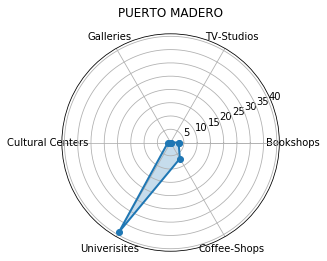

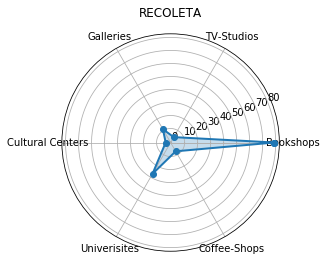

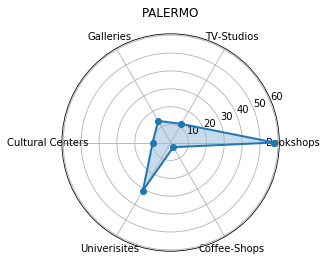

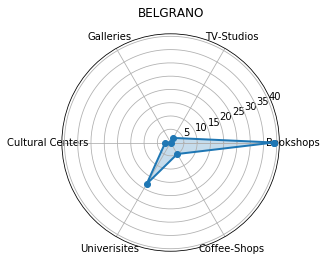

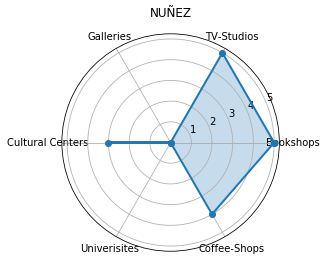

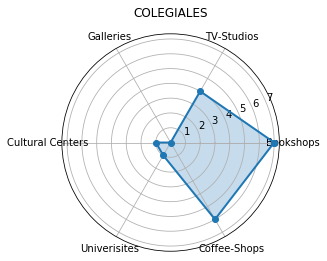

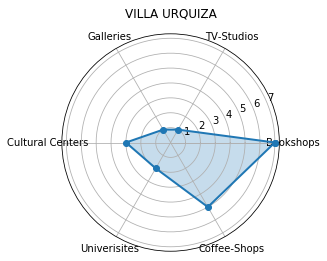

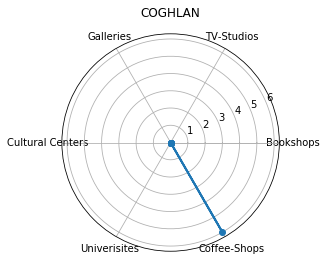

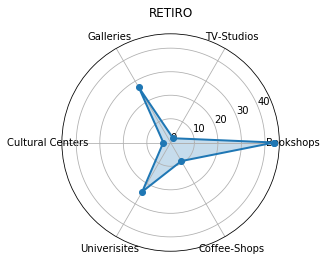

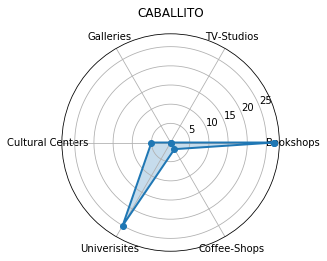

In [69]:
make_radar(res)

I defined a function to get the details of each venue in Foursquare

In [70]:
def get_venue_details(id):

    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Retrieve the detailed information of each of the Coffee Shops in the candidate neighborhoods

In [72]:
columns_names=['Neighborhood', 'ID','Name','Rating','Likes','Tips']
coffee_shops=pd.DataFrame(columns=columns_names)


for neighborhood, Id, name in zip(shops.Neighborhood, shops.id, shops.Venue):
    try:
        details = get_venue_details(Id)
        #print(details)
        Id,name,likes,rating,tips=details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',Id)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        Id,name,likes,rating,tips=[0]*5
    #print('(',count,'/',len(indian_rest_ny),')','processed')
    coffee_shops = coffee_shops.append({
                                                'Neighborhood': neighborhood, 
                                                'ID': Id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)


We save the details information in a csv file

In [73]:
coffee_shops.to_csv('coffee_shops_details.csv')

In [74]:
coffee_shops

Neighborhood                        ID  \
0   PUERTO MADERO  559053ea498e40e260853343   
1   PUERTO MADERO  4cc11a9aaa5776b057bd7544   
2   PUERTO MADERO  55d324f6498e77961d1e62ca   
3   PUERTO MADERO  5a3fb7d42619ee7032ea5017   
4   PUERTO MADERO  5c799eea82a750002c041285   
5   PUERTO MADERO  55611133498e91a2bd60d666   
6   PUERTO MADERO  56f2936a498eb646d65205a0   
7        RECOLETA  597a19364ce0663bda851ddc   
8        RECOLETA  55e06f5f498e06a1c0265db1   
9        RECOLETA  56f2936a498eb646d65205a0   
10       RECOLETA  55611133498e91a2bd60d666   
11       RECOLETA  5c799eea82a750002c041285   
12       RECOLETA  52376b960493653142d0cef4   
13       RECOLETA  5a3fb7d42619ee7032ea5017   
14        PALERMO  5957efd9029a55239dcf7e81   
15        PALERMO  5734f25b498ef99659a726ed   
16        PALERMO  542c714a498ed1d8ff638938   
17       BELGRANO  533a07ef498e7da2d4c49a24   
18       BELGRANO  561931bc498e240b6bcf5959   
19       BELGRANO  59f46e595f68b95033f30b0d   
20       BELGRANO  5734f25b498ef99659a726ed   
21       BELGRANO  550ad147498e2cb189e9132c   
22          NUÑEZ  53dfc405498ed10c9ed78947   
23          NUÑEZ  533a07ef498e7da2d4c49a24   
24          NUÑEZ  561931bc498e240b6bcf5959   
25          NUÑEZ  55fafc6f498e007c7fb23062   
26     COLEGIALES  561931bc498e240b6bcf5959   
27     COLEGIALES  533a07ef498e7da2d4c49a24   
28     COLEGIALES  5734f25b498ef99659a726ed   
29     COLEGIALES  542c714a498ed1d8ff638938   
30     COLEGIALES  54086c1b498ed14679e08732   
31     COLEGIALES  59f46e595f68b95033f30b0d   
32  VILLA URQUIZA  550ad147498e2cb189e9132c   
33  VILLA URQUIZA  59f46e595f68b95033f30b0d   
34  VILLA URQUIZA  4eb0b2c1f5b931e2adf68572   
35  VILLA URQUIZA  561931bc498e240b6bcf5959   
36  VILLA URQUIZA  533a07ef498e7da2d4c49a24   
37        COGHLAN  533a07ef498e7da2d4c49a24   
38        COGHLAN  561931bc498e240b6bcf5959   
39        COGHLAN  59f46e595f68b95033f30b0d   
40        COGHLAN  550ad147498e2cb189e9132c   
41        COGHLAN  53dfc405498ed10c9ed78947   
42        COGHLAN  55fafc6f498e007c7fb23062   
43         RETIRO  52376b960493653142d0cef4   
44         RETIRO  56f2936a498eb646d65205a0   
45         RETIRO  55e06f5f498e06a1c0265db1   
46         RETIRO  55611133498e91a2bd60d666   
47         RETIRO  5a3fb7d42619ee7032ea5017   
48         RETIRO  5c799eea82a750002c041285   
49         RETIRO  597a19364ce0663bda851ddc   
50         RETIRO  58876233e18e65245174c742   
51         RETIRO  55d324f6498e77961d1e62ca   
52      CABALLITO  5957efd9029a55239dcf7e81   
53      CABALLITO  542c714a498ed1d8ff638938   

                                   Name  Rating Likes Tips  
0             Ol'days (Coffee and Deli)     8.3   110   45  
1                             Starbucks     8.4   406   86  
2                             Starbucks     8.4    74   10  
3                       All Saints Cafe     8.8    53   23  
4                     Tostado Café Club     8.9    16    7  
5                  NEGRO. Cueva de café     8.9   190   79  
6                  NEGRO. Cueva de Café     9.2   110   46  
7                             Starbucks     8.7    36    3  
8                    The Shelter Coffee     8.8   102   34  
9                  NEGRO. Cueva de Café     9.2   110   46  
10                 NEGRO. Cueva de café     8.9   190   79  
11                    Tostado Café Club     8.9    16    7  
12                            Starbucks     8.7    70    8  
13                      All Saints Cafe     8.8    53   23  
14                          Cuervo Café     9.3   106   51  
15                            Vive Café     8.5    39   20  
16  LAB Training Center and Coffee Shop     8.8   345  113  
17                      All Saints Cafe     8.8   439  209  
18                            Le Ruelle     8.8    26   10  
19              Cigaló Specialty Coffee     8.4    34   17  
20                            Vive Café     8.5    39   20  
21                       Usina Cafetera     8.5   114   65  
22              

I convert the values into integers to be able to perform statistics

In [75]:
coffee_shops["Likes"] = coffee_shops["Likes"].astype(str).astype(int)
coffee_shops["Tips"] = coffee_shops["Tips"].astype(str).astype(int)
coffee_shops

Neighborhood                        ID  \
0   PUERTO MADERO  559053ea498e40e260853343   
1   PUERTO MADERO  4cc11a9aaa5776b057bd7544   
2   PUERTO MADERO  55d324f6498e77961d1e62ca   
3   PUERTO MADERO  5a3fb7d42619ee7032ea5017   
4   PUERTO MADERO  5c799eea82a750002c041285   
5   PUERTO MADERO  55611133498e91a2bd60d666   
6   PUERTO MADERO  56f2936a498eb646d65205a0   
7        RECOLETA  597a19364ce0663bda851ddc   
8        RECOLETA  55e06f5f498e06a1c0265db1   
9        RECOLETA  56f2936a498eb646d65205a0   
10       RECOLETA  55611133498e91a2bd60d666   
11       RECOLETA  5c799eea82a750002c041285   
12       RECOLETA  52376b960493653142d0cef4   
13       RECOLETA  5a3fb7d42619ee7032ea5017   
14        PALERMO  5957efd9029a55239dcf7e81   
15        PALERMO  5734f25b498ef99659a726ed   
16        PALERMO  542c714a498ed1d8ff638938   
17       BELGRANO  533a07ef498e7da2d4c49a24   
18       BELGRANO  561931bc498e240b6bcf5959   
19       BELGRANO  59f46e595f68b95033f30b0d   
20       BELGRANO  5734f25b498ef99659a726ed   
21       BELGRANO  550ad147498e2cb189e9132c   
22          NUÑEZ  53dfc405498ed10c9ed78947   
23          NUÑEZ  533a07ef498e7da2d4c49a24   
24          NUÑEZ  561931bc498e240b6bcf5959   
25          NUÑEZ  55fafc6f498e007c7fb23062   
26     COLEGIALES  561931bc498e240b6bcf5959   
27     COLEGIALES  533a07ef498e7da2d4c49a24   
28     COLEGIALES  5734f25b498ef99659a726ed   
29     COLEGIALES  542c714a498ed1d8ff638938   
30     COLEGIALES  54086c1b498ed14679e08732   
31     COLEGIALES  59f46e595f68b95033f30b0d   
32  VILLA URQUIZA  550ad147498e2cb189e9132c   
33  VILLA URQUIZA  59f46e595f68b95033f30b0d   
34  VILLA URQUIZA  4eb0b2c1f5b931e2adf68572   
35  VILLA URQUIZA  561931bc498e240b6bcf5959   
36  VILLA URQUIZA  533a07ef498e7da2d4c49a24   
37        COGHLAN  533a07ef498e7da2d4c49a24   
38        COGHLAN  561931bc498e240b6bcf5959   
39        COGHLAN  59f46e595f68b95033f30b0d   
40        COGHLAN  550ad147498e2cb189e9132c   
41        COGHLAN  53dfc405498ed10c9ed78947   
42        COGHLAN  55fafc6f498e007c7fb23062   
43         RETIRO  52376b960493653142d0cef4   
44         RETIRO  56f2936a498eb646d65205a0   
45         RETIRO  55e06f5f498e06a1c0265db1   
46         RETIRO  55611133498e91a2bd60d666   
47         RETIRO  5a3fb7d42619ee7032ea5017   
48         RETIRO  5c799eea82a750002c041285   
49         RETIRO  597a19364ce0663bda851ddc   
50         RETIRO  58876233e18e65245174c742   
51         RETIRO  55d324f6498e77961d1e62ca   
52      CABALLITO  5957efd9029a55239dcf7e81   
53      CABALLITO  542c714a498ed1d8ff638938   

                                   Name  Rating  Likes  Tips  
0             Ol'days (Coffee and Deli)     8.3    110    45  
1                             Starbucks     8.4    406    86  
2                             Starbucks     8.4     74    10  
3                       All Saints Cafe     8.8     53    23  
4                     Tostado Café Club     8.9     16     7  
5                  NEGRO. Cueva de café     8.9    190    79  
6                  NEGRO. Cueva de Café     9.2    110    46  
7                             Starbucks     8.7     36     3  
8                    The Shelter Coffee     8.8    102    34  
9                  NEGRO. Cueva de Café     9.2    110    46  
10                 NEGRO. Cueva de café     8.9    190    79  
11                    Tostado Café Club     8.9     16     7  
12                            Starbucks     8.7     70     8  
13                      All Saints Cafe     8.8     53    23  
14                          Cuervo Café     9.3    106    51  
15                            Vive Café     8.5     39    20  
16  LAB Training Center and Coffee Shop     8.8    345   113  
17                      All Saints Cafe     8.8    439   209  
18                            Le Ruelle     8.8     26    10  
19              Cigaló Specialty Coffee     8.4     34    17  
20                            Vive Café     8.5     39    20  
21                       Usina Ca

We will count how many Coffe Shops there are per neighborhood and calculate the Average Rating, Likes and Tips of each

In [76]:
stats = coffee_shops.groupby(["Neighborhood"], as_index=False).agg({'Rating' : 'mean', "Likes" : 'mean', "Tips": "mean", 'Name' : 'count'})
stats.rename(columns={"Rating": "AVG Rating","Likes": "AVG Likes","Tips": "AVG Tips","Name":"Count"}, inplace=True)
stats.sort_values("AVG Rating")

Neighborhood  AVG Rating   AVG Likes   AVG Tips  Count
2        COGHLAN    8.466667  128.833333  52.833333      6
4          NUÑEZ    8.475000  156.250000  58.750000      4
0       BELGRANO    8.600000  130.400000  64.200000      5
9  VILLA URQUIZA    8.600000  144.400000  68.800000      5
3     COLEGIALES    8.616667  182.666667  65.833333      6
6  PUERTO MADERO    8.700000  137.000000  42.285714      7
8         RETIRO    8.766667   75.555556  23.666667      9
7       RECOLETA    8.857143   82.428571  28.571429      7
5        PALERMO    8.866667  163.333333  61.333333      3
1      CABALLITO    9.050000  225.500000  82.000000      2

Let's see that information in a bar chart

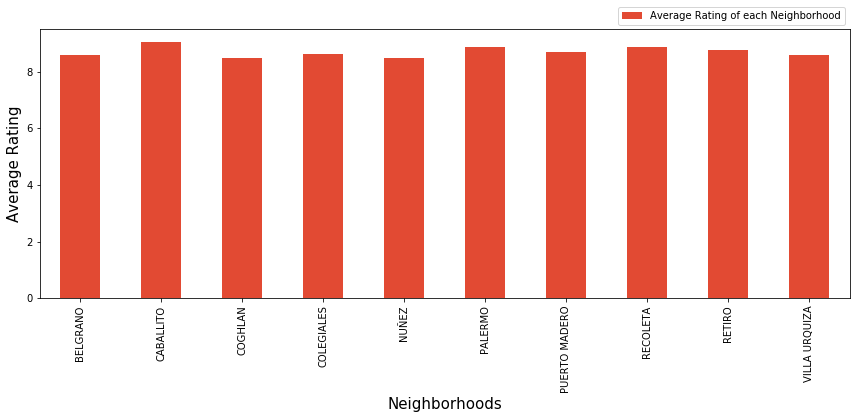

In [77]:
ax = stats.plot(kind='bar', x='Neighborhood', y='AVG Rating', figsize=(12,6), color='#E24A33')
ax.legend(["Average Rating of each Neighborhood"],bbox_to_anchor=(1, 1.1));
fig = ax.get_figure()
ax.set_ylabel("Average Rating",fontsize = 15)
ax.set_xlabel("Neighborhoods",fontsize = 15)
fig.tight_layout()
fig.savefig("stats.png")

As we see, Rating averages are very similar between neighborhoods. We can see that Caballito is the neighborhood that has less Coffee Shops and the one with the highest average. Puerto Madero and Retiro are the ones with the most Coffee Shops

Let's see this on a map

In [78]:
rating_map = folium.Map(location=[ba_center[0], ba_center[1]], zoom_start=12)
rating_map.choropleth(
    geo_data=ba_geo,
    data=stats,
    columns=['Neighborhood', 'AVG Rating'],
    key_on='feature.properties.barrio',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name="Average Rating per Neigborhood"
)

# display map
rating_map.save('rating_map.html')
rating_map

Now let's see the amount of Coffee Shops in each Neighborhood

In [79]:
count_map = folium.Map(location=[ba_center[0], ba_center[1]], zoom_start=12)
count_map.choropleth(
    geo_data=ba_geo,
    data=stats,
    columns=['Neighborhood', 'Count'],
    key_on='feature.properties.barrio',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name="Quantity of Coffee Shops per Neigborhood"
)

# display map
count_map.save('count_map.html')
count_map

### Discuss

We discovered that Puerto Madero, Recoleta and Palermo are the most expensive neighborhoods to live, and so they are also the ones with more coffee shops. Caballito is the cheapest neighborhood and also the one with few coffee shops.

Palermo, Retiro and Recoleta are the neighborhoods with more cultural activity. Puerto Madero is where there are more universities. In the middle is Caballito with an acceptable amount of Universities and Cultural Activities.

Puerto Madero and Retiro are the neighborhood with more coffee shops, but the customer's rating isn’t the best.

Caballito is the best ranked on Coffee Shops Rating, Nuñez is the neighborhood with the worst rating.


### Conclusions

#### Based on the results described above, we find we can conclude that: 
Caballito has the potential to open a Starbucks. It’s the neighborhood where there are fewer Coffee Shops and the average price of m2 is the lowest. It also has a significant number of Universities, Theaters, Cinemas, Cultural Centers which make the neighborhood a meeting point for many people and make this neighborhood the best candidate due to the low price and the low exploitation of the market.